<a href="https://colab.research.google.com/github/gawronn91/Airbnb/blob/main/Riga.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://medium.datadriveninvestor.com/airbnb-listings-analysis-in-toronto-october-2018-2a5358bae007
ciekawy linczek
https://www.kaggle.com/code/yaowenling/berlin-airbnb-data-exploration-public/notebook

Plan jest taki, żeby zrobić 4 bieguny
1. Tanio i miejscko - Ryga
2. Drogo i miejsko - Londyn/Paryż/Sztokcholm/Mediolan/Barcelona
3. Tanio i wiejsko - Puglia
4. Drogo i wiejsko - Vaduz w Szwajcarii

Warto dodac info, że nas nie interesują shared room/ private room, tylko całe apartamenty!!!!

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, explained_variance_score, max_error, mean_absolute_percentage_error, r2_score, mean_poisson_deviance
from sklearn.linear_model import lasso_path
import xgboost
!pip install shap
import shap

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 564 kB 3.1 MB/s 


Loading data

In [ ]:
url='https://drive.google.com/file/d/1NY3h3O17BPSw8Ffr5wtkg0ziXtwA39Xi/view?usp=sharing'
file_id=url.split('/')[-2]
dwn_url='https://drive.google.com/uc?id=' + file_id

data = pd.read_csv(dwn_url, encoding_errors='ignore')

Tables display settings

In [ ]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

Printing columns

In [ ]:
data.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_upd

Printing data info

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2128 entries, 0 to 2127
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            2128 non-null   int64  
 1   listing_url                                   2128 non-null   object 
 2   scrape_id                                     2128 non-null   int64  
 3   last_scraped                                  2128 non-null   object 
 4   name                                          2128 non-null   object 
 5   description                                   2078 non-null   object 
 6   neighborhood_overview                         1242 non-null   object 
 7   picture_url                                   2128 non-null   object 
 8   host_id                                       2128 non-null   int64  
 9   host_url                                      2128 non-null   o

Listing columns with missing data

In [ ]:
listings_na = data.isna().sum()
listings_na[listings_na.values > 0].sort_values(ascending=False)

bathrooms                       2128
calendar_updated                2128
license                         2128
neighbourhood_group_cleansed    2128
host_neighbourhood              2101
host_about                      1136
neighborhood_overview            886
neighbourhood                    886
host_response_rate               646
host_response_time               646
host_acceptance_rate             444
review_scores_communication      344
review_scores_cleanliness        344
review_scores_accuracy           344
review_scores_location           344
review_scores_value              344
review_scores_checkin            344
review_scores_rating             329
last_review                      329
first_review                     329
reviews_per_month                329
bedrooms                         314
description                       50
beds                              45
bathrooms_text                     2
host_identity_verified             2
host_has_profile_pic               2
h

Describing price column

In [ ]:
data.describe(include="all")["price"]

count       2128
unique       215
top       $25.00
freq          88
mean         NaN
std          NaN
min          NaN
25%          NaN
50%          NaN
75%          NaN
max          NaN
Name: price, dtype: object

Converting price values from object to float

In [ ]:
data["price"] = data["price"].apply(lambda x: x.replace("$", "")) # Remove dollar sign
data["price"] = data["price"].apply(lambda x: x.replace(",", "")) # Remove thousand seperator
data["price"] = data["price"].astype("float") # Cast the column into type float
data.describe(include="all")["price"]

count     2128.000000
unique            NaN
top               NaN
freq              NaN
mean        92.960056
std        368.173416
min          8.000000
25%         30.750000
50%         49.000000
75%         75.000000
max       5000.000000
Name: price, dtype: float64

Getting rid of outliers

In [ ]:
print("100% properties have a price lower than {0: .2f}".format(np.percentile(data.price, 99)))
# Since 99% entries have a price that is lower than 500 , we choose to remove the rest as outliers.
# We would like to create a new column "price_range" for visualisations later on. The choice of cutoff points (e.g. 20, 40, 60, etc) is inspired by the quartiles of column "price".

100% properties have a price lower than  500.00


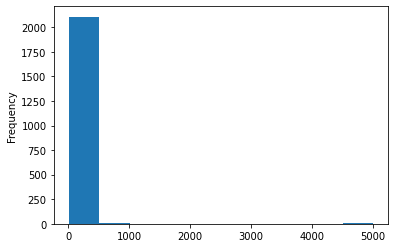

In [ ]:
data.price.plot.hist()
#This data needs to be trimmed due to outliers

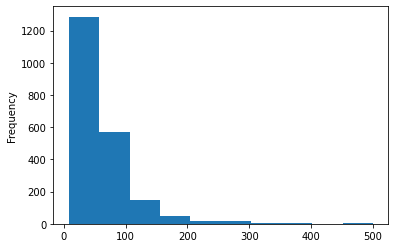

In [ ]:
data = data[(data.price <= np.percentile(data["price"], 99)) & (data.price > 0)] # Exclude outliers
data.price.plot.hist()

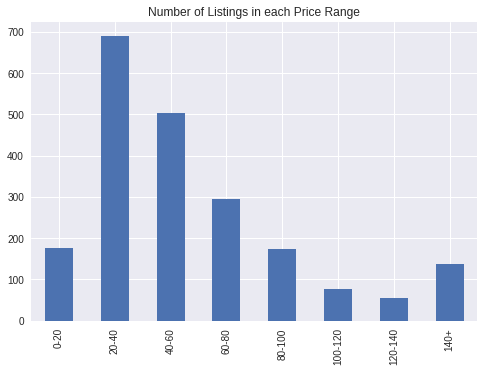

In [ ]:
plt.style.use("seaborn")
price_range = pd.cut(data["price"], 
                     bins=[0, 20, 40, 60, 80, 100, 120, 140, data["price"].max()], 
                     labels=["0-20", "20-40", "40-60", "60-80", "80-100", "100-120", "120-140", "140+"])
data["price_range"] = price_range 
data["price_range"].value_counts().sort_index().plot(kind="bar")
plt.title("Number of Listings in each Price Range")
plt.show()

Store variable names that might be interesting for exploration

In [ ]:
selected = []
host = ['host_is_superhost', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_identity_verified']
location = ['neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed']
geo = ["latitude", "longitude"]
condition = ['property_type', 'room_type', 'bed_type', 'amenities', 'cleaning_fee', 'minimum_nights']
review = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value']
size = ['space', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'square_feet']
others = ['instant_bookable', 'is_business_travel_ready', 'cancellation_policy']

Host statistics - i will introduce 2 examples of drawing the data by matplotlib

# Plots about hosts

In [ ]:
data.describe(include="all")[host]

,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_identity_verified
count,2105,27,2105.000000,2105.000000,2107,2105
unique,2,10,NaN,NaN,122,2
top,f,Vecrīga,NaN,NaN,"['email', 'phone']",t
freq,1355,13,NaN,NaN,385,1548
mean,NaN,NaN,4.879810,4.879810,NaN,NaN
std,NaN,NaN,7.853718,7.853718,NaN,NaN
min,NaN,NaN,0.000000,0.000000,NaN,NaN
25%,NaN,NaN,1.000000,1.000000,NaN,NaN
50%,NaN,NaN,2.000000,2.000000,NaN,NaN
75%,NaN,NaN,6.000000,6.000000,NaN,NaN


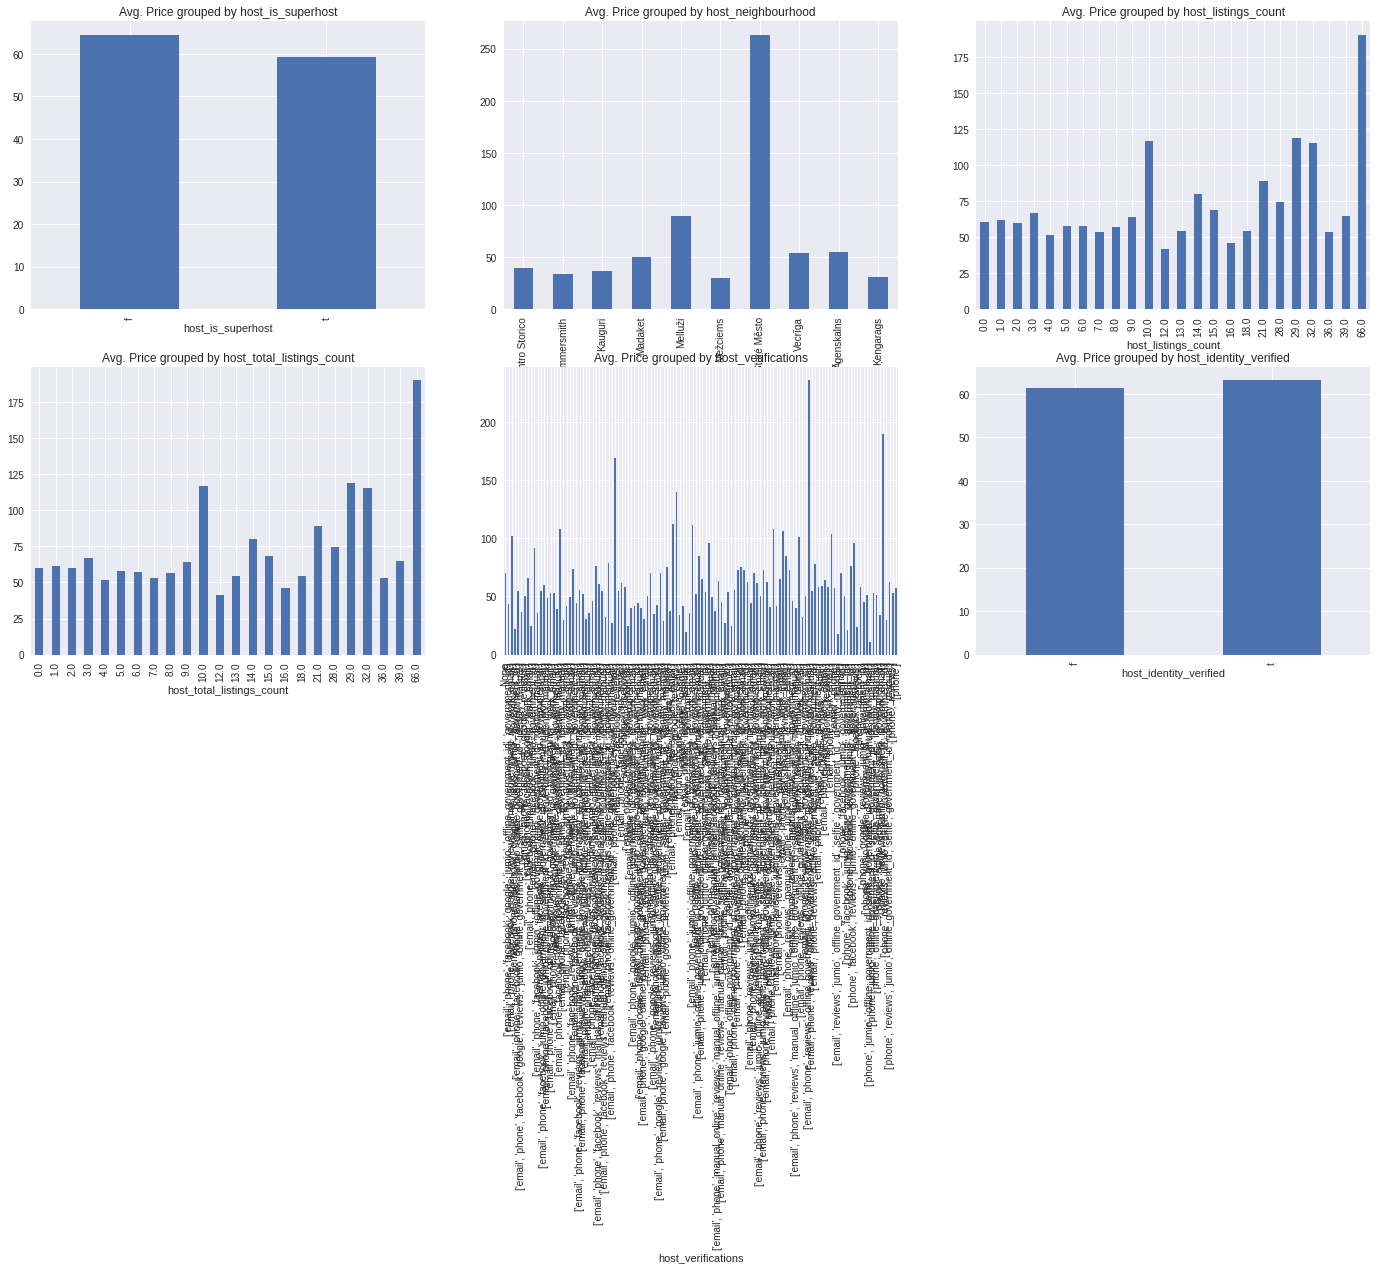

In [ ]:
n_cols = 3
n_rows = np.ceil((len(host)+1)/n_cols)
i = 1
for col in host:
  plt.subplot(n_rows, n_cols, i)
  avg_price_host = data.groupby(col).mean()["price"]
  avg_price_host.plot(kind="bar", figsize=(8*n_cols, 6*n_rows))
  plt.title("Avg. Price grouped by "+col)
  i=i+1

plt.show()

Plots above says that we shall limit those with lots of unique values

In [ ]:
index = []
i=0
for col in host:
  if data[col].nunique() >= 10:
    index.append(i)
    i=i+1
  else:
    i=i+1
    continue
host = np.delete(host, index)

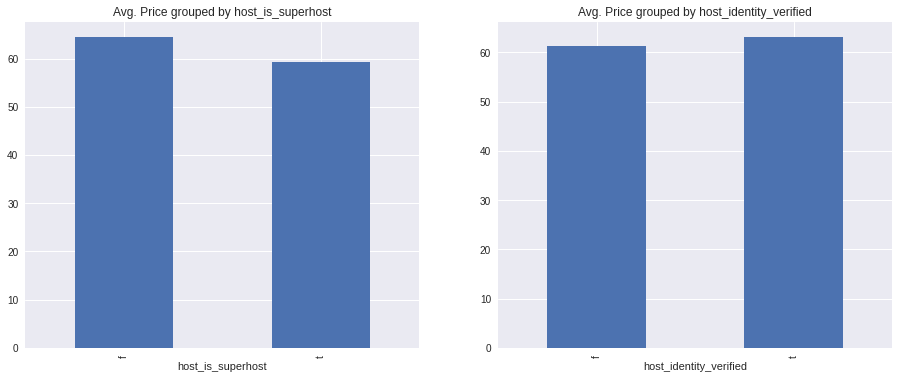

In [ ]:
n_cols = 3
n_rows = np.ceil((len(host)+1)/n_cols)
i = 1
for col in host:
  plt.subplot(n_rows, n_cols, i)
  avg_price_host = data.groupby(col).mean()["price"]
  avg_price_host.plot(kind="bar", figsize=(8*n_cols, 6*n_rows))
  plt.title("Avg. Price grouped by "+col)
  i=i+1

plt.show()

Powyżej widzimy Wybrane histogramy, które nam odpowiadają, bo mają odpowiednio małą ilość parametrów

#Adjusting host data

Since columns "host_is_superhost" and "host_identity_verified" are of data type Boolean, we would fill out missing values with False.

In [ ]:
data["host_is_superhost"] = data["host_is_superhost"].replace(np.NAN, "f")
data["host_identity_verified"] =data["host_identity_verified"].replace(np.NAN, "f")

Now we can perform a statistical test - dokładniej t-test

In [ ]:
from scipy import stats
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison)
# Define multicomp function
def multicomp(target_name, group_name, data):
    if (np.nan in data[target_name]) | (np.nan in data[group_name]):
        print("Please remove NaN in target variable or group variable!")
    elif (data[target_name].nunique() == 1) | (data[group_name].nunique() == 1):
        print("There is only one unique value in target variable or group variable.")
    elif data[group_name].nunique() == 2:
        mod = MultiComparison(data[target_name], data[group_name])
        comp = mod.allpairtest(stats.ttest_ind)
        print(comp[0])
    else:
        mod = MultiComparison(data[target_name], data[group_name])
        print(mod.tukeyhsd().summary())
multicomp("price", "host_is_superhost", data)
multicomp("price", "host_identity_verified", data)

Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.05, alphacBonf=0.050
group1 group2  stat   pval pval_corr reject
-------------------------------------------
     f      t 2.0656 0.039     0.039   True
-------------------------------------------
Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.05, alphacBonf=0.050
group1 group2   stat   pval  pval_corr reject
---------------------------------------------
     f      t -0.6537 0.5134    0.5134  False
---------------------------------------------


Widzimy tutaj, że zmienna host_is_superhost jest relevant, ale w host_identity_verified nie udało się odrzucic hipotezy zerowej, więc możemy uznać ją za niepotrzebną

Stworzymy więc listę o nazwie selected, do której będziemy dodawać zmienne istotne statystycznie

In [ ]:
selected.append("host_is_superhost")
selected

['host_is_superhost']

Teraz możemy zająć się host verifications

In [ ]:
# Changing ['email', 'phone', 'reviews'] to [email, phone, reviews]
data["host_ver_types"] = data["host_verifications"].apply(lambda x: x[1:-1].replace("\'", "").split(", "))
data["host_ver_types"]

0                                 [email, phone, reviews]
1       [email, phone, reviews, jumio, offline_governm...
2       [email, phone, reviews, jumio, offline_governm...
3                                 [email, phone, reviews]
4       [email, phone, facebook, reviews, jumio, gover...
5                       [email, phone, facebook, reviews]
6                                 [email, phone, reviews]
7       [email, phone, reviews, jumio, offline_governm...
8       [email, phone, facebook, reviews, jumio, offli...
9       [email, phone, reviews, jumio, offline_governm...
10      [email, phone, reviews, jumio, offline_governm...
11      [email, phone, reviews, jumio, offline_governm...
12      [email, phone, reviews, jumio, offline_governm...
13      [email, phone, reviews, jumio, offline_governm...
14      [email, phone, facebook, reviews, jumio, offli...
15      [email, phone, reviews, jumio, offline_governm...
16      [email, phone, reviews, jumio, offline_governm...
17      [email

In [ ]:
# Counting number of verification types in the apartment
data["host_ver_type_counts"] = data["host_ver_types"].apply(lambda x: len(x))
data["host_ver_type_counts"] 

0        3
1        8
2        8
3        3
4        6
5        4
6        3
7        8
8        7
9        8
10       8
11       8
12       8
13       8
14       7
15       7
16       8
17       6
18       7
19       3
20       5
21       8
22       8
23       6
24       5
25       7
26       2
27       7
28       7
29       4
30       8
31       5
32       7
33       8
34       7
35       8
36       3
37       8
38       7
39       8
40       5
41       8
42       8
43       7
44       7
45       7
46       8
47       5
50       5
51       5
52       6
53       5
54       8
55      10
56       6
57       6
58       3
59       5
60       5
61       5
62       7
63       6
64       3
65       8
66       5
67       8
68       2
69       4
70       8
71       8
72       8
73       5
74       3
75       1
76       6
77       5
78       3
81       8
82       5
83       5
84       2
85       3
86       6
87       5
88       3
89       6
90       7
91       6
92       5
93       7
94       3

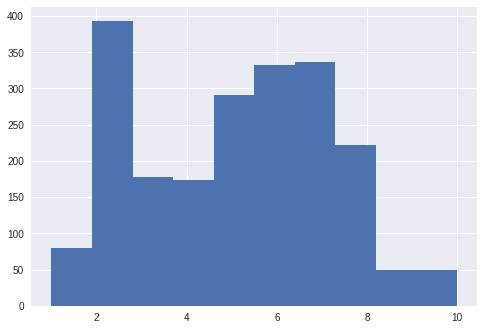

In [ ]:
data["host_ver_type_counts"].hist()

In [ ]:
# Here we iterate per all verification types and add to new list (with duplicates)
host_ver_types = []
for i in data["host_ver_types"]:
    host_ver_types += i

host_ver_types

['email',
 'phone',
 'reviews',
 'email',
 'phone',
 'reviews',
 'jumio',
 'offline_government_id',
 'selfie',
 'government_id',
 'identity_manual',
 'email',
 'phone',
 'reviews',
 'jumio',
 'offline_government_id',
 'selfie',
 'government_id',
 'identity_manual',
 'email',
 'phone',
 'reviews',
 'email',
 'phone',
 'facebook',
 'reviews',
 'jumio',
 'government_id',
 'email',
 'phone',
 'facebook',
 'reviews',
 'email',
 'phone',
 'reviews',
 'email',
 'phone',
 'reviews',
 'jumio',
 'offline_government_id',
 'selfie',
 'government_id',
 'identity_manual',
 'email',
 'phone',
 'facebook',
 'reviews',
 'jumio',
 'offline_government_id',
 'government_id',
 'email',
 'phone',
 'reviews',
 'jumio',
 'offline_government_id',
 'selfie',
 'government_id',
 'identity_manual',
 'email',
 'phone',
 'reviews',
 'jumio',
 'offline_government_id',
 'selfie',
 'government_id',
 'identity_manual',
 'email',
 'phone',
 'reviews',
 'jumio',
 'offline_government_id',
 'selfie',
 'government_id',
 'ide

In [ ]:
# Here we check count of verifications without replacement and put it in a dictionary
host_ver_types_freq = dict((x, host_ver_types.count(x)) for x in set(host_ver_types))
host_ver_types_freq

{'email': 1941,
 'facebook': 342,
 'google': 127,
 'government_id': 1316,
 'identity_manual': 621,
 'jumio': 1053,
 'kba': 1,
 'manual_offline': 30,
 'manual_online': 14,
 'offline_government_id': 1005,
 'on': 2,
 'phone': 2103,
 'photographer': 2,
 'reviews': 1020,
 'selfie': 644,
 'work_email': 399,
 'zhima_selfie': 7}

In [ ]:
# Creating a DataFreame from dictionary created above
host_ver_types_freq = pd.DataFrame.from_dict(host_ver_types_freq, orient="index")
# Reseting an index and changing column names
host_ver_types_freq.reset_index(inplace=True)
host_ver_types_freq.columns = ["Verification", "Frequency"]
# Picking most frequent verification types in selected order
host_ver_types_freq = host_ver_types_freq.sort_values(by="Frequency", ascending=True)
host_ver_types_freq = host_ver_types_freq[host_ver_types_freq.Frequency >25]
host_ver_types_freq

,Verification,Frequency
10,kba,1
8,photographer,2
6,on,2
5,zhima_selfie,7
16,manual_online,14
4,manual_offline,30
3,google,127
1,facebook,342
13,work_email,399
14,identity_manual,621


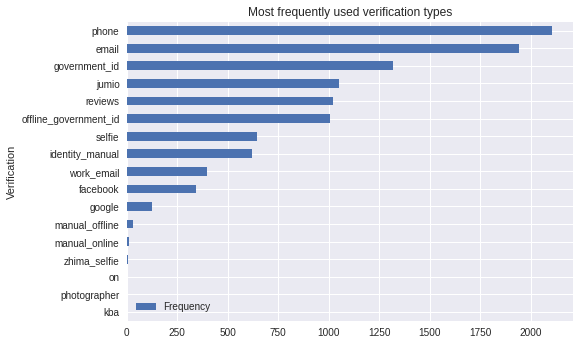

In [ ]:
host_ver_types_freq.plot.barh(x="Verification", y="Frequency")
plt.title("Most frequently used verification types")
plt.show()

#Geoplot 

In [ ]:
import plotly.graph_objects as go
import plotly.express as px
from plotly import tools
from plotly.offline import plot as plotoffline
import seaborn as sns

Creating a dataset

In [ ]:
geo = data[['latitude', 'longitude', 'price', 'price_range']]
geo = geo.sort_values("price", ascending=True) # This sorting is necessary for the color scale to work properly. 
geo.describe()

,latitude,longitude,price
count,2107.000000,2107.000000,2107.000000
mean,56.953781,24.117827,62.616042
std,0.017037,0.033523,53.613502
min,56.867120,23.968620,8.000000
25%,56.948160,24.107115,30.000000
50%,56.951920,24.121100,48.000000
75%,56.958135,24.132930,74.000000
max,57.082000,24.267930,500.000000


Simple scatter plot

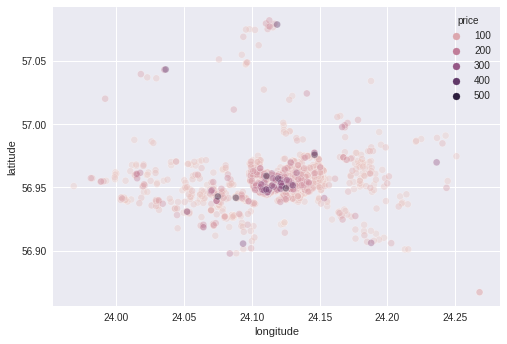

In [ ]:
sns.scatterplot(x="longitude", 
                y="latitude", 
                hue="price", 
                data=geo, 
                alpha=0.4)

Below we have created map with marked prices from several ranges

In [ ]:
# Map plot
from textwrap import wrap

px.set_mapbox_access_token("pk.eyJ1IjoiZ2F3cm9ubiIsImEiOiJjbDNzeXllNWkxMnl4M2psdHRtZGZkODh0In0.hSntC8Rp50ICzYyvo606nA") # Replace XXX with your Mapbox Token

#Token created here: https://account.mapbox.com/access-tokens 
#I think, that simmilar map could be generated via one of books from python - ćwiczenia
fig = px.scatter_mapbox(geo, 
                        lat="latitude", 
                        lon="longitude", 
                        color="price_range",
                        color_continuous_scale=px.colors.sequential.Aggrnyl,# Na tej stronie można sobie wybierać różne skale kolorów https://plotly.com/python/builtin-colorscales/
                        opacity=0.9, 
                        zoom=10)
fig.show()

In [ ]:
data.neighbourhood_cleansed.unique()

array(['Avoti', 'Centrs', 'VecpilsÄ\x93ta', 'Ä\x80genskalns',
       'Maskavas forÅ¡tate', 'TorÅ\x86akalns', 'Sarkandaugava', 'Brasa',
       'Ä¶engarags', 'PÄ\x93tersala-Andrejsala', 'PleskodÄ\x81le',
       'BieriÅ\x86i', 'GrÄ«ziÅ\x86kalns', 'Teika', 'Purvciems', 'Imanta',
       'Ziepniekkalns', 'Jugla', 'Dzirciems', 'IÄ¼Ä£uciems', 'MeÅ¾ciems',
       'VecÄ\x81Ä·i', 'Ä¶Ä«psala', 'Skanste', 'PÄ¼avnieki', 'MeÅ¾aparks',
       'BiÅ¡umuiÅ¾a', 'ZolitÅ«de', 'Zasulauks', 'Kleisti', 'BeberbeÄ·i',
       'BuÄ¼Ä¼i', 'DÄ\x81rzciems', 'MÄ«lgrÄ\x81vis', 'Salas',
       'DÄ\x81rziÅ\x86i', 'DaugavgrÄ«va', 'MangaÄ¼sala', 'Jaunciems',
       'Ä\x8ciekurkalns', 'DreiliÅ\x86i', 'Vecdaugava', 'Voleri',
       'Å\xa0ampÄ\x93teris', 'Å\xa0Ä·irotava', 'AtgÄ\x81zene',
       'VecmÄ«lgrÄ\x81vis'], dtype=object)

To better evaluate the location of each listing, we would like to calcuate the distance between each listing and one of the Top5 locations in Riga. Here we define the Top5 locations as:

Old Town - https://www.latvia.travel/en/sight/old-town-riga

Riga Central Market - https://www.latvia.travel/en/sight/riga-central-market

The Freedom Monument - https://www.latvia.travel/en/sight/freedom-monument

Alberta Street - https://www.latvia.travel/en/sight/alberta-street

Latvian National Opera and Ballet - https://www.latvia.travel/en/sight/latvian-national-opera-and-ballet

Top 5 neighbourhoods in Riga:
VecpilsÄ\x93ta

Centrs

Avoti

Skanste

Maskavas forÅ¡tate

Calcuate the distance bwteen the listing and mianat tractions in Riga

In [ ]:
# Formula to calculate distances
from math import sin, cos, sqrt, atan2, radians
def distance(lat1, lat2, lon1, lon2):
    R = 6373.0
    rlat1 = radians(lat1)
    rlat2 = radians(lat2)
    rlon1 = radians(lon1)
    rlon2 = radians(lon2)
    rdlon = rlon2 - rlon1
    rdlat = rlat2 - rlat1
    a = sin(rdlat / 2)**2 + cos(rlat1) * cos(rlat2) * sin(rdlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance

In [ ]:
# Top locations in Riga
toploc = {"Old_Town": [56.949144, 24.106130], 
          "Market": [56.943728, 24.114706], 
          "Monument": [56.951526, 24.113365], 
          "Alberta": [56.959063, 24.109703], 
          "Opera": [56.949543, 24.113829]}

In [ ]:
toploc = pd.DataFrame.from_dict(toploc)
toploc_trans = toploc.transpose()
toploc_trans.columns = ["latitude", "longitude"]

In [ ]:
# Draw a plot with top locations

fig = px.scatter_mapbox(toploc_trans, 
                        lat="latitude", 
                        lon="longitude", 
                        zoom=10)
fig.show()

In [ ]:
# Construct distance columns
dist = []
for col in toploc.columns:
    data["dist_"+col] = data.apply(lambda x: distance(x.latitude, toploc[col][0], x.longitude, toploc[col][1]), axis=1)
    dist.append("dist_"+col)

# In "dist" list there are names of all hot locations
# Here we are counting the distance between an apartment nand selected hot location. So we have 5 new numerical columns.

Poniżej przedstawienie 5 ostatnich kolumn w tabeli danych

In [ ]:
data.iloc[:5, -5:]

,dist_Old_Town,dist_Market,dist_Monument,dist_Alberta,dist_Opera
0,1.627072,1.450565,1.147870,1.539648,1.164921
1,1.390589,1.547331,0.881285,0.945736,1.016999
2,0.284157,1.047396,0.481595,0.862196,0.561739
3,1.787750,2.068207,2.300381,2.682491,2.217992
4,0.130069,0.705765,0.417393,1.121614,0.342993


The correlation between price and dist_Old_Town is -0.0635 with a p-value of  0.0035.
The correlation between price and dist_Market is -0.0378 with a p-value of  0.0828.
The correlation between price and dist_Monument is -0.0503 with a p-value of  0.0210.
The correlation between price and dist_Alberta is -0.0442 with a p-value of  0.0423.
The correlation between price and dist_Opera is -0.0496 with a p-value of  0.0227.


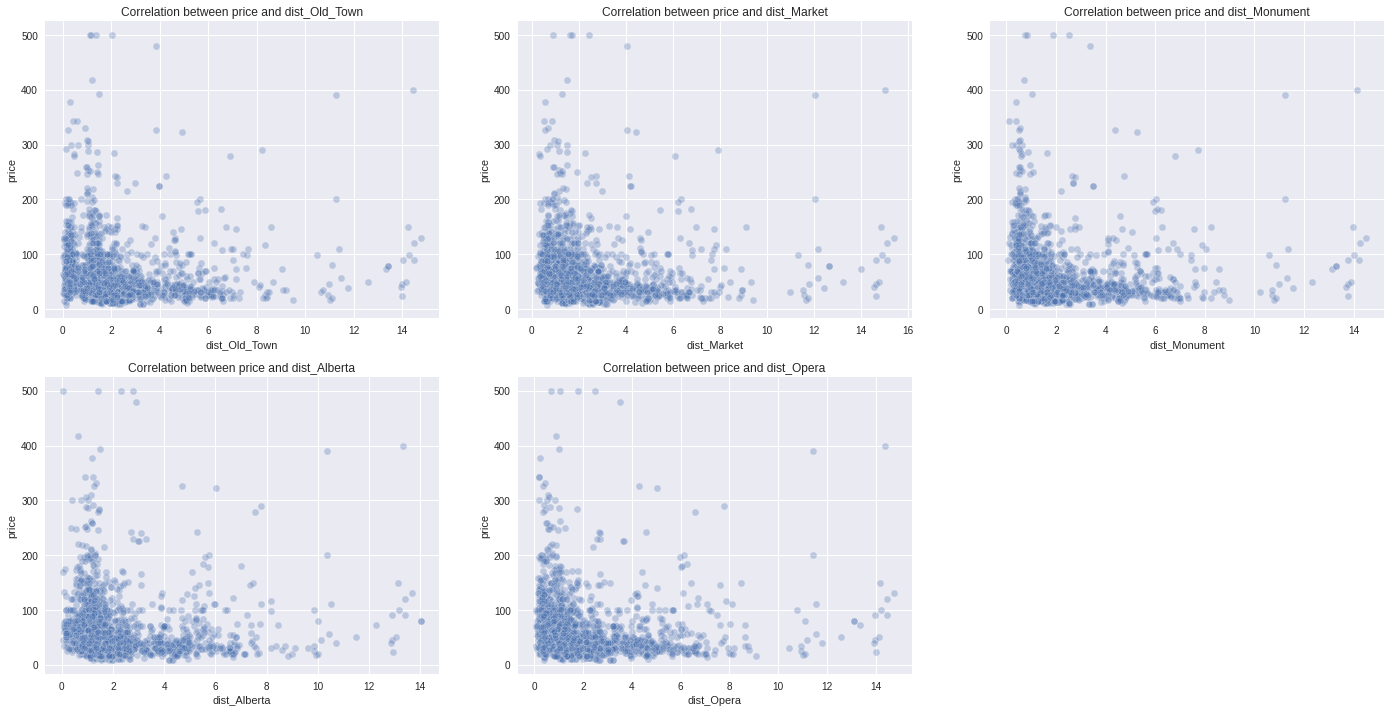

In [ ]:
# Here we count and plot Pearson correlation between distance to selected top location and a price
n_cols = 3
n_rows = np.ceil((len(dist)+1)/n_cols)
i = 1
plt.figure(figsize=(8*n_cols, 6*n_rows))
for distance in dist:
  plt.subplot(n_rows, n_cols, i)
  sns.scatterplot(x=distance, y="price", data=data, alpha=0.3)
  plt.title("Correlation between price and "+distance)
  i=i+1
  print("The correlation between price and "+distance+ " is {0[0]: .4f} with a p-value of {0[1]: .4f}.".format(stats.pearsonr(data[-data[distance].isna()][distance], data[-data[distance].isna()]["price"])))

plt.show()

Note, that p is higher, than 0.05 only for Central Market - we could take it under consideration in the future!

For now, we are just aware, that there is a strong corelation.

In [ ]:
# Next step is to categorize distance columns to True, False (Close, Not close)
for distance in dist:
   data[distance+"_close"] = (data[distance] < 0.8 * (data[distance].median()))
   print(data.groupby(distance+"_close").mean()["price"])

# Finaly we can add one last column with the verdict - can we mark an appartment as well located
toploc_column_names = ['dist_{0}_close'.format(i) for i in toploc.columns]
data["good_distance"] = data.apply(lambda x: any(x[col] for col in toploc_column_names), axis=1)

dist_Old_Town_close
False    51.644213
True     73.598291
Name: price, dtype: float64
dist_Market_close
False    55.483871
True     69.754986
Name: price, dtype: float64
dist_Monument_close
False    52.410816
True     72.830959
Name: price, dtype: float64
dist_Alberta_close
False    53.553131
True     71.687559
Name: price, dtype: float64
dist_Opera_close
False    53.045541
True     72.195632
Name: price, dtype: float64


We can see histogram below, which informs us, that mean price of locations with small distance to top 5 attractions in the city is higher.

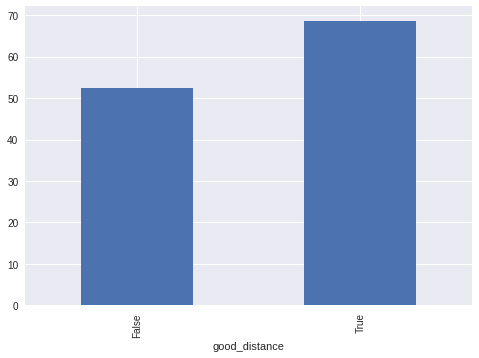

In [ ]:
data.groupby("good_distance").mean()["price"].plot(kind="bar")
plt.show()

In [ ]:
data.iloc[:5, -6:]

,dist_Old_Town_close,dist_Market_close,dist_Monument_close,dist_Alberta_close,dist_Opera_close,good_distance
0,False,True,True,False,True,True
1,True,True,True,True,True,True
2,True,True,True,True,True,True
3,False,False,False,False,False,False
4,True,True,True,True,True,True


We can append then this criterion to our selected table:

In [ ]:
selected.append("good_distance")
selected

['host_is_superhost', 'good_distance']

#Neighbourhood statistics


We would also like to check the popularity and price level at each neighbourhood of Riga.

In [ ]:
# Top popular nerghbourhoods
neighbourhood_group_pop = pd.DataFrame(data["neighbourhood_cleansed"].value_counts())
neighbourhood_group_pop.head(5)

,neighbourhood_cleansed
Centrs,656
VecpilsÄta,393
Avoti,291
GrÄ«ziÅkalns,106
Maskavas forÅ¡tate,98


In [ ]:
# Average price of each neighbourhood
neighbourhood_group_price = data.groupby("neighbourhood_cleansed").mean()["price"]
neighbourhood_group_price = pd.DataFrame(neighbourhood_group_price)
neighbourhood_group_price.sort_values("price", ascending=False).head(5)

,price
neighbourhood_cleansed,
MeÅ¾ciems,162.500000
DaugavgrÄ«va,156.000000
Å Ä·irotava,146.000000
Voleri,110.000000
VecÄÄ·i,109.166667


In [ ]:
# Create neighbourhood stats
neighbourhood_stat = pd.merge(neighbourhood_group_pop, 
                              neighbourhood_group_price, 
                              how="inner", left_index=True, right_index=True)
neighbourhood_stat.reset_index(inplace=True)
neighbourhood_stat.columns = ["neighbourhood_cleansed", "count_properties", "avg_price"]
neighbourhood_stat = neighbourhood_stat.sort_values(by="count_properties", ascending=False)
neighbourhood_stat.head(10)

,neighbourhood_cleansed,count_properties,avg_price
0,Centrs,656,67.339939
1,VecpilsÄta,393,77.936387
2,Avoti,291,55.037801
3,GrÄ«ziÅkalns,106,36.924528
4,Maskavas forÅ¡tate,98,46.561224
5,Ägenskalns,93,64.612903
6,Brasa,52,58.019231
7,TorÅakalns,44,48.840909
8,Imanta,43,59.325581
9,PÄtersala-Andrejsala,40,51.525000


In [ ]:
#Addition of filter, which consists of neighbourhoods with at least XXXX properties
neighbourhood_stat_limited = neighbourhood_stat[neighbourhood_stat['count_properties']>40]

Below getting rid of Latvian letters - important note, that letters were changed only in set_limited to above 40 locals in one neighbourhood!!

In [ ]:
!pip install unidecode
import unidecode
neighbourhood_stat_limited['neighbourhood_cleansed'] = neighbourhood_stat_limited['neighbourhood_cleansed'].apply(lambda x: unidecode.unidecode(x))
neighbourhood_stat_limited

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 235 kB 4.2 MB/s 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,neighbourhood_cleansed,count_properties,avg_price
0,Centrs,656,67.339939
1,VecpilsAta,393,77.936387
2,Avoti,291,55.037801
3,GrA<<ziAkalns,106,36.924528
4,Maskavas forA!tate,98,46.561224
5,Agenskalns,93,64.612903
6,Brasa,52,58.019231
7,TorAakalns,44,48.840909
8,Imanta,43,59.325581


<Figure size 576x396 with 0 Axes>

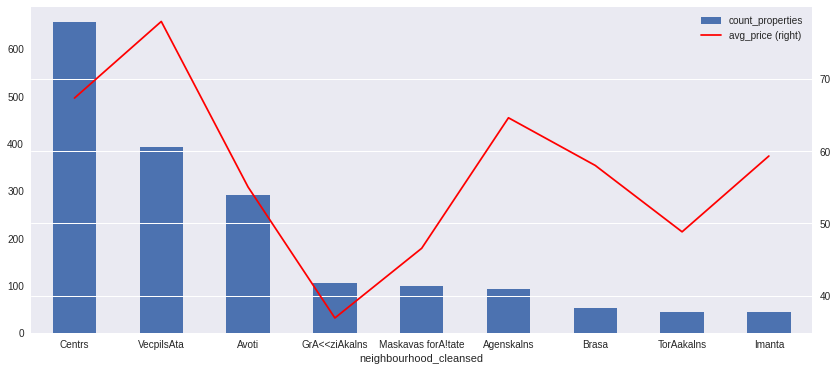

In [ ]:
#Drawing a plot with relation - No. of properties vs avg price in selected neighbourhood
fig = plt.figure()
ax = neighbourhood_stat_limited.plot(x="neighbourhood_cleansed", y="count_properties", kind="bar", figsize=(14, 6))
neighbourhood_stat_limited.plot(x="neighbourhood_cleansed", y="avg_price", secondary_y=True, color="red", ax=ax)
plt.show()

#Condition statistics

We would also like to check the impact of conditions.

In [ ]:
condition = ['property_type', 'room_type', 'amenities', 'minimum_nights', 'maximum_nights']

In [ ]:
data[condition].head()

,property_type,room_type,amenities,minimum_nights,maximum_nights
0,Private room in rental unit,Private room,"[""Room-darkening shades"", ""Wifi"", ""Indoor fire...",60,1125
1,Entire rental unit,Entire home/apt,"[""Wifi"", ""Dedicated workspace"", ""Cable TV"", ""E...",2,730
2,Entire rental unit,Entire home/apt,"[""Wifi"", ""Indoor fireplace"", ""Essentials"", ""Ki...",2,730
3,Entire rental unit,Entire home/apt,"[""Oven"", ""Wifi"", ""Smoke alarm"", ""Hot water ket...",4,1125
4,Entire rental unit,Entire home/apt,"[""Wifi"", ""Smoke alarm"", ""Refrigerator"", ""Lockb...",2,5


Property type

In [ ]:
# Table with selected property type and average price per property type
prop_type_avg_price = data.groupby("property_type").mean()["price"]
prop_type_count_listings = data["property_type"].value_counts()
prop_type_stat = pd.merge(prop_type_count_listings, prop_type_avg_price, how="inner", left_index=True, right_index=True)
prop_type_stat.columns = ["count_prop", "avg_price"]
prop_type_stat.sort_values(by="count_prop", ascending=False).head(10)

,count_prop,avg_price
Entire rental unit,1546,62.093144
Private room in rental unit,113,49.778761
Entire serviced apartment,92,77.065217
Entire condominium (condo),90,59.488889
Entire loft,46,87.782609
Entire residential home,28,116.607143
Room in aparthotel,22,61.727273
Private room in serviced apartment,21,17.904762
Room in boutique hotel,16,84.000000
Private room in residential home,16,67.562500


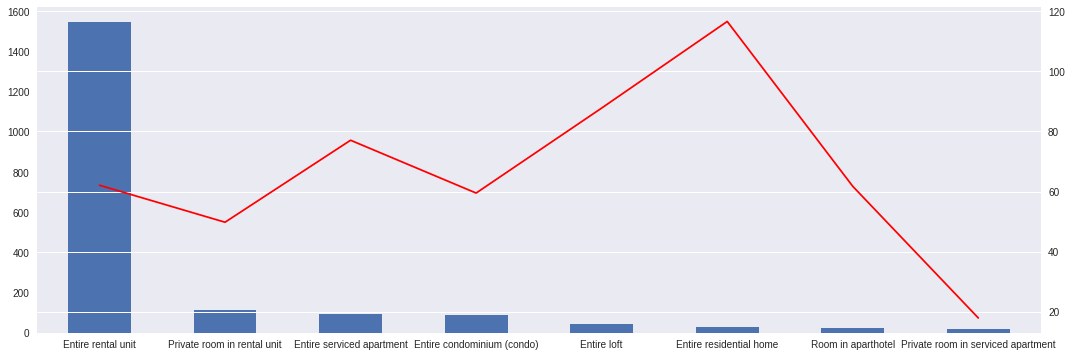

In [ ]:
# Drawing a plot with relation - No. of properties vs avg price in selected property type
prop_type_stat_limited = prop_type_stat[prop_type_stat['count_prop']>20] #Trzeba było ograniczyć liczbe rodzajów lokli
fig = plt.figure()
ax = prop_type_stat_limited['count_prop'].plot(x="neighbourhood_cleansed", y="count_properties", kind="bar", figsize=(18, 6))
prop_type_stat_limited['avg_price'].plot(x="neighbourhood_cleansed", y="avg_price", secondary_y=True, color="red", ax=ax)
plt.show()

Room type

In [ ]:
# Table with selected room type and average price per room type
room_type_avg_price = data.groupby("room_type").mean()["price"]
room_type_count_listings = data["room_type"].value_counts()
room_type_stat = pd.merge(room_type_count_listings, room_type_avg_price, how="inner", left_index=True, right_index=True)
room_type_stat.columns = ["count_prop", "avg_price"]
room_type_stat.sort_values(by="count_prop", ascending=False).head(10)

,count_prop,avg_price
Entire home/apt,1858,64.742196
Private room,214,46.126168
Shared room,26,26.538462
Hotel room,9,120.000000


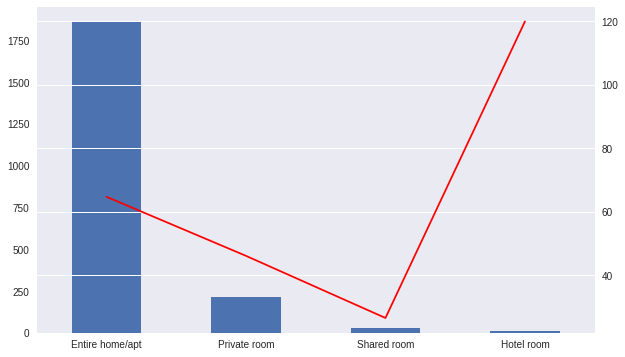

In [ ]:
# Drawing a plot with relation - No. of properties vs avg price in selected room type
fig = plt.figure()
ax = room_type_stat['count_prop'].plot(x="neighbourhood_cleansed", y="count_properties", kind="bar", figsize=(10, 6))
room_type_stat['avg_price'].plot(x="neighbourhood_cleansed", y="avg_price", secondary_y=True, color="red", ax=ax)
plt.show()

Entire apartment has a significant higher price than a private room. Therefore we take it into our model.

In [ ]:
data["is_entire_apt"] = data["room_type"]=="Entire home/apt"
selected.append("is_entire_apt")

Amendities

In [ ]:
data["amenities"].head()

0    ["Room-darkening shades", "Wifi", "Indoor fire...
1    ["Wifi", "Dedicated workspace", "Cable TV", "E...
2    ["Wifi", "Indoor fireplace", "Essentials", "Ki...
3    ["Oven", "Wifi", "Smoke alarm", "Hot water ket...
4    ["Wifi", "Smoke alarm", "Refrigerator", "Lockb...
Name: amenities, dtype: object

In [ ]:
data["amenities"] =data["amenities"].apply(lambda x: x[1:-1].replace("\'", "").replace(' "', '').replace('"', '').split(","))
data["amenities"].head()

0    [Room-darkening shades, Wifi, Indoor fireplace...
1    [Wifi, Dedicated workspace, Cable TV, Essentia...
2    [Wifi, Indoor fireplace, Essentials, Kitchen, ...
3    [Oven, Wifi, Smoke alarm, Hot water kettle, Es...
4    [Wifi, Smoke alarm, Refrigerator, Lockbox, Hea...
Name: amenities, dtype: object

In [ ]:
# Listing all amenities
amenity_types = []
for i in data["amenities"]:
    amenity_types += i
amenity_types

['Room-darkening shades',
 'Wifi',
 'Indoor fireplace',
 'Dining table',
 'Essentials',
 'Kitchen',
 'Heating',
 'Hot water',
 'Dryer',
 'Hangers',
 'Iron',
 'Bed linens',
 'Refrigerator',
 'Dishes and silverware',
 'Long term stays allowed',
 'Bathtub',
 'Washer',
 'Drying rack for clothing',
 'Wifi',
 'Dedicated workspace',
 'Cable TV',
 'Essentials',
 'Kitchen',
 'TV with standard cable',
 'Hot water',
 'Iron',
 'Hangers',
 'Shampoo',
 'Stove',
 'Microwave',
 'Coffee maker',
 'Refrigerator',
 'Dishes and silverware',
 'Hair dryer',
 'Long term stays allowed',
 'Heating',
 'Cooking basics',
 'Wifi',
 'Indoor fireplace',
 'Essentials',
 'Kitchen',
 'Cooking basics',
 'Hot water',
 'Shampoo',
 'Dishes and silverware',
 'Long term stays allowed',
 'Heating',
 'Air conditioning',
 'Oven',
 'Wifi',
 'Smoke alarm',
 'Hot water kettle',
 'Essentials',
 'Kitchen',
 'Cooking basics',
 'Hot water',
 'Refrigerator',
 'Bed linens',
 'Dishes and silverware',
 'Free street parking',
 'Long term st

In [ ]:
# Table with amenities and their frequency
amenity_types_freq = dict((x, amenity_types.count(x)) for x in set(amenity_types))
amenity_types_freq = pd.DataFrame.from_dict(amenity_types_freq, orient="index")
amenity_types_freq.reset_index(inplace=True)
amenity_types_freq.columns = ["Amenity", "Frequency"]
amenity_types_freq = amenity_types_freq.sort_values(by="Frequency", ascending=False)
amenity_types_freq.head(25)

,Amenity,Frequency
98,Wifi,2025
249,Kitchen,1990
69,Essentials,1988
155,Long term stays allowed,1953
347,Hangers,1820
287,Heating,1801
374,Hair dryer,1794
379,Iron,1704
10,Washer,1637
138,Hot water,1578


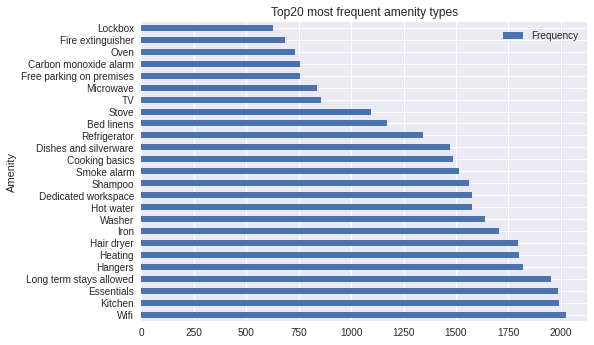

In [ ]:
# Plot with top amenities
amenity_types_freq.head(25).plot.barh(x="Amenity", y="Frequency")
plt.title("Top20 most frequent amenity types")
plt.show()

90%+ listings have the Top3 features: kitchen, Essentials and heatLong term stays allowed. Therefore they won't have a huge impact on price. We choose to focuse on features that ~50% listings have. They are:

TV

Stove

Wifi

Refrigerator


In [ ]:
# Creating new dummy columns for selected amenities
data["with_TV"] = data["amenities"].apply(lambda x: 'TV' in x)
data["with_Stove"] =data["amenities"].apply(lambda x: 'Stove' in x)
data["with_Wifi"] = data["amenities"].apply(lambda x: 'Wifi' in x)
data["with_Refrigerator"] = data["amenities"].apply(lambda x: 'Refrigerator' in x)

In [ ]:
data.iloc[:10, -4:]

,with_TV,with_Stove,with_Wifi,with_Refrigerator
0,False,False,True,True
1,False,True,True,True
2,False,False,True,False
3,False,False,True,True
4,False,True,True,True
5,False,True,True,True
6,False,False,True,True
7,False,True,True,True
8,False,False,True,False
9,False,True,True,True


In [ ]:
# Performing statistical test for selected amenities
print(multicomp("price", "with_TV", data))
print(multicomp("price", "with_Stove", data))
print(multicomp("price", "with_Wifi", data))
print(multicomp("price", "with_Refrigerator", data))

Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.05, alphacBonf=0.050
group1 group2  stat   pval  pval_corr reject
--------------------------------------------
 False   True -3.672 0.0002    0.0002   True
--------------------------------------------
None
Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.05, alphacBonf=0.050
group1 group2  stat   pval  pval_corr reject
--------------------------------------------
 False   True 0.4212 0.6737    0.6737  False
--------------------------------------------
None
Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.05, alphacBonf=0.050
group1 group2  stat   pval  pval_corr reject
--------------------------------------------
 False   True 0.1922 0.8476    0.8476  False
--------------------------------------------
None
Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.05, alphacBonf=0.050
group1 group2  stat  pval  pval_corr reject
-----------------------------

We can see here, that null hypotesis was rejected only for TV. We could try then 3 another amenities, to improve our predictions.
Lets add:

Microwave

Bed linens

Dishes and silverware

In [ ]:
data["with_Microwave"] =data["amenities"].apply(lambda x: 'Microwave' in x)
data["with_Bed linens"] = data["amenities"].apply(lambda x: 'Bed linens' in x)
data["with_Dishes and silverware"] = data["amenities"].apply(lambda x: 'Dishes and silverware' in x)

In [ ]:
print(multicomp("price", "with_Microwave", data))
print(multicomp("price", "with_Bed linens", data))
print(multicomp("price", "with_Dishes and silverware", data))

Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.05, alphacBonf=0.050
group1 group2  stat   pval  pval_corr reject
--------------------------------------------
 False   True -2.571 0.0102    0.0102   True
--------------------------------------------
None
Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.05, alphacBonf=0.050
group1 group2  stat  pval pval_corr reject
------------------------------------------
 False   True 1.5987 0.11      0.11  False
------------------------------------------
None
Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.05, alphacBonf=0.050
group1 group2  stat   pval  pval_corr reject
--------------------------------------------
 False   True 1.3485 0.1776    0.1776  False
--------------------------------------------
None


We have rejected null hypotesis only for TV and microvawe - lets look for another one

In [ ]:
data["with_Free parking on premises"] =data["amenities"].apply(lambda x: 'Free parking on premises' in x)
data["with_Carbon_monoxide_alarm"] = data["amenities"].apply(lambda x: 'Carbon monoxide alarm' in x)

In [ ]:
print(multicomp("price", "with_Free parking on premises", data))
print(multicomp("price", "with_Carbon_monoxide_alarm", data))

Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.05, alphacBonf=0.050
group1 group2  stat   pval  pval_corr reject
--------------------------------------------
 False   True 1.1297 0.2587    0.2587  False
--------------------------------------------
None
Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.05, alphacBonf=0.050
group1 group2   stat   pval  pval_corr reject
---------------------------------------------
 False   True -2.4324 0.0151    0.0151   True
---------------------------------------------
None


Last amenity to add is Carbon monoxide alarm

In [ ]:
for i in ["with_TV", "with_Microwave", "with_Carbon_monoxide_alarm"]:
    selected.append(i)

In [ ]:
selected

['host_is_superhost',
 'good_distance',
 'is_entire_apt',
 'with_TV',
 'with_Microwave',
 'with_Carbon_monoxide_alarm']

Minimum nights

In [ ]:
data["minimum_nights"].describe()

count    2107.000000
mean        5.285714
std        24.351162
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max       365.000000
Name: minimum_nights, dtype: float64

In [ ]:
data["min_nights_greater_than_two"] = data["minimum_nights"] > 2
multicomp("price", "min_nights_greater_than_two", data=data)

Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.05, alphacBonf=0.050
group1 group2  stat   pval  pval_corr reject
--------------------------------------------
 False   True 3.4936 0.0005    0.0005   True
--------------------------------------------


Conclusion: properties that require at least 3 nights have sig. higher price.

Lets see about maximum nights

In [ ]:
data["maximum_nights"].describe()

count     2107.000000
mean       707.116754
std        525.898627
min          1.000000
25%        120.000000
50%       1125.000000
75%       1125.000000
max      10000.000000
Name: maximum_nights, dtype: float64

it is hard to estimate something here, so lets ged rid of this max nights criterion

In [ ]:
selected.append("min_nights_greater_than_two")

Here cleaning fee could appear. in Riga data it is not available

#<h1>  Review statistics </h1>

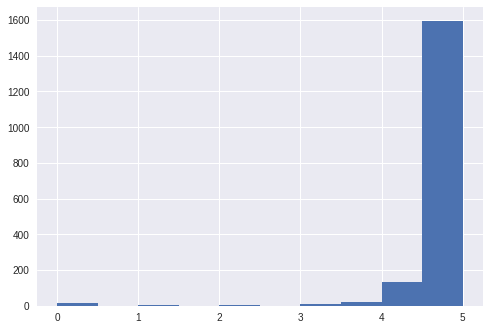

In [ ]:
data["review_scores_rating"].hist()

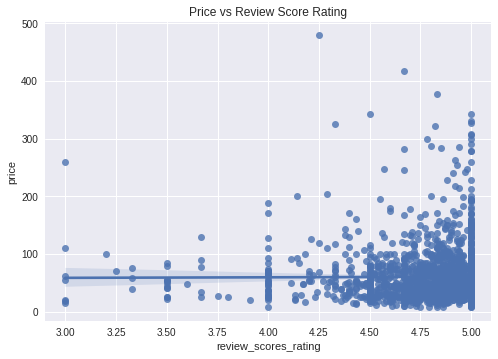

The correlation between review score and price is -0.0388 with a p-value of  0.1013.


In [ ]:
# Scatter plot between review score and price
import seaborn as sns
import scipy.stats as stats
sns.regplot(x="review_scores_rating", y="price", data=data[data["review_scores_rating"]>=3])
plt.title("Price vs Review Score Rating")
plt.show()
print("The correlation between review score and price is {0[0]: .4f} with a p-value of {0[1]: .4f}.".format(stats.pearsonr(data[-data["review_scores_rating"].isna()]["review_scores_rating"], data[-data["review_scores_rating"].isna()]["price"])))

There is no significant correlation between review score and price.

Check the correlation between price and other scores

In [ ]:
for col in review:
    print(("The pearson correlation coefficient between " + col + " and price is {0[0]: .4f} with a p-value of {0[1]: .4f}.").format(stats.pearsonr(data[-data[col].isna()][col],data[-data[col].isna()]["price"])))

The pearson correlation coefficient between review_scores_rating and price is -0.0388 with a p-value of  0.1013.
The pearson correlation coefficient between review_scores_accuracy and price is -0.0313 with a p-value of  0.1887.
The pearson correlation coefficient between review_scores_cleanliness and price is  0.0311 with a p-value of  0.1907.
The pearson correlation coefficient between review_scores_checkin and price is  0.0073 with a p-value of  0.7582.
The pearson correlation coefficient between review_scores_communication and price is -0.0340 with a p-value of  0.1533.
The pearson correlation coefficient between review_scores_location and price is  0.0696 with a p-value of  0.0034.
The pearson correlation coefficient between review_scores_value and price is -0.0486 with a p-value of  0.0411.


There is no significant correlation between other review scores and price.

#<h1> Size of apartment</h1>

Look at size-related variables

In [ ]:
#Need to adjust data to Riga provided columns
size = ['accommodates', 'bathrooms', 'bedrooms', 'beds']
data[size].head(10)

,accommodates,bathrooms,bedrooms,beds
0,1,NaN,1.0,1.0
1,2,NaN,1.0,3.0
2,5,NaN,2.0,2.0
3,3,NaN,1.0,1.0
4,2,NaN,1.0,1.0
5,4,NaN,1.0,2.0
6,7,NaN,2.0,5.0
7,4,NaN,1.0,3.0
8,5,NaN,2.0,2.0
9,4,NaN,1.0,3.0


In [ ]:
data['bathrooms'].describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: bathrooms, dtype: float64

it occour, that there are no valuable info in bathrooms column

In [ ]:
data['bathrooms_text'].unique()

array(['1 shared bath', '1 bath', '1.5 baths', '1.5 shared baths',
       '3.5 shared baths', '2 baths', '0 baths', 'Half-bath', '2.5 baths',
       '3 baths', '1 private bath', '4 shared baths', 'Shared half-bath',
       '3.5 baths', '2 shared baths', '4.5 baths', nan, '4 baths',
       '2.5 shared baths', '5.5 baths', '5.5 shared baths', '36 baths'],
      dtype=object)

But we count find something interesting in 'bathrooms_text column'

In [ ]:
data['bathrooms'] = np.where(data['bathrooms_text'].str.contains('half',case=False, na=False), 0.5, 
                          data['bathrooms_text'].str.split().str[0]).astype(np.float64)
data[size].head(10)

,accommodates,bathrooms,bedrooms,beds
0,1,1.0,1.0,1.0
1,2,1.0,1.0,3.0
2,5,1.0,2.0,2.0
3,3,1.0,1.0,1.0
4,2,1.0,1.0,1.0
5,4,1.0,1.0,2.0
6,7,1.5,2.0,5.0
7,4,1.0,1.0,3.0
8,5,1.5,2.0,2.0
9,4,1.0,1.0,3.0


Check the correlation between number of accommodates and price

In [ ]:
data["accommodates"].describe()

count    2107.000000
mean        3.853346
std         2.380046
min         1.000000
25%         2.000000
50%         4.000000
75%         4.000000
max        16.000000
Name: accommodates, dtype: float64

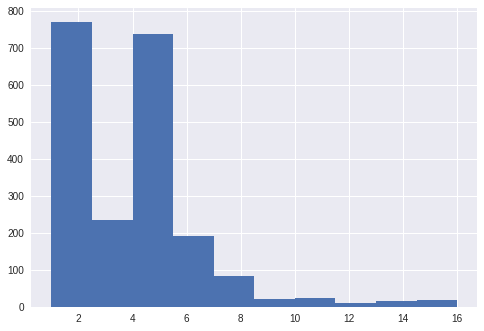

In [ ]:
data["accommodates"].hist()

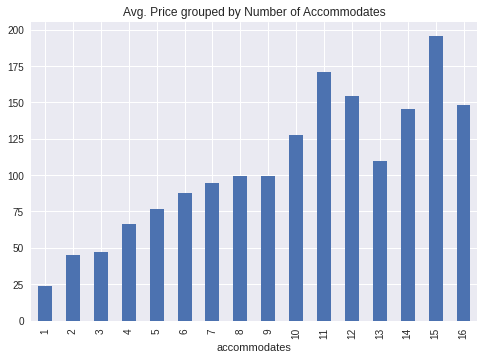

The pearson correlation coefficient between ther number of acoommodates and price is  0.4260 with a p-value of  0.0000.


In [ ]:
data.groupby("accommodates").mean()["price"].plot(kind="bar")
plt.title("Avg. Price grouped by Number of Accommodates")
plt.show()
print("The pearson correlation coefficient between ther number of acoommodates and price is {0[0]: .4f} with a p-value of {0[1]: .4f}.".format(stats.pearsonr(data["accommodates"], data["price"])))

Accommodates can be used as a proxy of space and has sig. correlation with price.

In [ ]:
selected.append("accommodates")
selected

['host_is_superhost',
 'good_distance',
 'is_entire_apt',
 'with_TV',
 'with_Microwave',
 'with_Carbon_monoxide_alarm',
 'min_nights_greater_than_two',
 'accommodates']

Check the correlation bewteen accommodates and other size variables

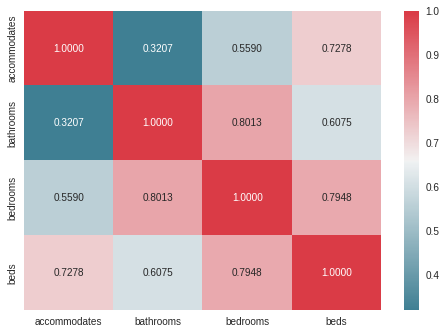

In [ ]:
size_variables = data[size]
size_corr = size_variables.corr()
colormap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(size_corr, cmap=colormap, annot=True, fmt=".4f")

Conclusion: the variable "accommodates" is highly correlated with "beds" and "bedrooms", so it is sufficient to include only accommodates into our model.

#<h1>Other conditions</h1>

In [ ]:
# I had to limit it due to Riga data
others = ['instant_bookable']
data[others].head()

,instant_bookable
0,f
1,f
2,f
3,f
4,f


Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.05, alphacBonf=0.050
group1 group2  stat   pval  pval_corr reject
--------------------------------------------
     f      t 2.1291 0.0334    0.0334   True
--------------------------------------------


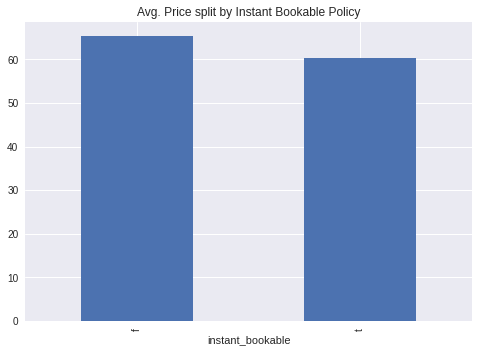

In [ ]:
data["instant_bookable"].value_counts()
multicomp("price", "instant_bookable", data)
data.groupby("instant_bookable").mean()["price"].plot(kind="bar")
plt.title("Avg. Price split by Instant Bookable Policy")
plt.show()


Możemy więc dodać nasze instant bookable

In [ ]:
selected.append("instant_bookable")
selected

['host_is_superhost',
 'good_distance',
 'is_entire_apt',
 'with_TV',
 'with_Microwave',
 'with_Carbon_monoxide_alarm',
 'min_nights_greater_than_two',
 'accommodates',
 'instant_bookable']

We have all selected values!!!

#Feature Engineering

In [ ]:
data[selected].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2107 entries, 0 to 2127
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   host_is_superhost            2107 non-null   object
 1   good_distance                2107 non-null   bool  
 2   is_entire_apt                2107 non-null   bool  
 3   with_TV                      2107 non-null   bool  
 4   with_Microwave               2107 non-null   bool  
 5   with_Carbon_monoxide_alarm   2107 non-null   bool  
 6   min_nights_greater_than_two  2107 non-null   bool  
 7   accommodates                 2107 non-null   int64 
 8   instant_bookable             2107 non-null   object
dtypes: bool(6), int64(1), object(2)
memory usage: 78.2+ KB


Convert string variables into categorical variables

In [ ]:
data["host_is_superhost"] = data["host_is_superhost"]=="t"
data["instant_bookable"] = data["instant_bookable"]=="t"

In [ ]:
for col in data[selected].select_dtypes("bool").columns:
    data[col] = data[col].astype("int")

In [ ]:
data[selected].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2107 entries, 0 to 2127
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   host_is_superhost            2107 non-null   int64
 1   good_distance                2107 non-null   int64
 2   is_entire_apt                2107 non-null   int64
 3   with_TV                      2107 non-null   int64
 4   with_Microwave               2107 non-null   int64
 5   with_Carbon_monoxide_alarm   2107 non-null   int64
 6   min_nights_greater_than_two  2107 non-null   int64
 7   accommodates                 2107 non-null   int64
 8   instant_bookable             2107 non-null   int64
dtypes: int64(9)
memory usage: 164.6 KB


Standardisation

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
scaledFeatures = sc.fit_transform(data[selected])
scaledFeatures

array([[-0.74343107,  0.76823738, -2.73163822, ...,  1.68668032,
        -1.19914648, -1.08889148],
       [-0.74343107,  0.76823738,  0.36608069, ..., -0.59288058,
        -0.77888673, -1.08889148],
       [-0.74343107,  0.76823738,  0.36608069, ..., -0.59288058,
         0.48189253, -1.08889148],
       ...,
       [-0.74343107,  0.76823738,  0.36608069, ..., -0.59288058,
         1.32241203, -1.08889148],
       [-0.74343107,  0.76823738,  0.36608069, ...,  1.68668032,
        -1.19914648,  0.91836516],
       [-0.74343107,  0.76823738,  0.36608069, ...,  1.68668032,
         0.06163278,  0.91836516]])

# Linear Regression

In [ ]:
import statsmodels.formula.api as smf

model = smf.ols('price ~ host_is_superhost + good_distance + is_entire_apt + with_TV + with_Microwave + with_Carbon_monoxide_alarm + min_nights_greater_than_two + accommodates + instant_bookable', data=data).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.209
Model:                            OLS   Adj. R-squared:                  0.205
Method:                 Least Squares   F-statistic:                     61.45
Date:                Tue, 31 May 2022   Prob (F-statistic):          3.53e-100
Time:                        22:17:05   Log-Likelihood:                -11132.
No. Observations:                2107   AIC:                         2.228e+04
Df Residuals:                    2097   BIC:                         2.234e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

We can say, that instant_bookable, min_nights_greater_than_two, with_Carbon_monoxide_alarm and with_Microwave have rather great p value, so we can delete them from model.

In [ ]:
model = smf.ols('price ~ host_is_superhost + good_distance + is_entire_apt + with_TV + accommodates', data=data).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.206
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     109.2
Date:                Tue, 31 May 2022   Prob (F-statistic):          9.89e-103
Time:                        22:17:05   Log-Likelihood:                -11136.
No. Observations:                2107   AIC:                         2.228e+04
Df Residuals:                    2101   BIC:                         2.232e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            10.2911      3.62

To improove understanding of proper infestment - I would like to add bedrooms coef (in place of acomodities) to the model. I will also remove host_is_superhost, due to negative impact.

In [ ]:
model = smf.ols('price ~ good_distance + is_entire_apt + with_TV + bedrooms', data=data).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                     50.68
Date:                Tue, 31 May 2022   Prob (F-statistic):           1.83e-40
Time:                        22:17:05   Log-Likelihood:                -9615.5
No. Observations:                1797   AIC:                         1.924e+04
Df Residuals:                    1792   BIC:                         1.927e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        18.8585      3.974      4.746

# XGB

In [ ]:
# Load packages and create test set
import xgboost as xgb
from xgboost import plot_importance
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error

X = scaledFeatures
y = data["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#Initialize XGBoost classifier and find the best parameter sets with Grid Search CV
xgb_clf = xgb.XGBRegressor()
parameters = {'n_estimators': [120, 100, 140], 'max_depth':[3,5,7,9]}
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=parameters, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

[22:17:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'max_depth': 3, 'n_estimators': 100}


In [ ]:
# Xgb with best parameters
xgb_clf = xgb.XGBRegressor(n_estimators=100, max_depth=3)
xgb_clf.fit(X_train, y_train)
y_test_pred = xgb_clf.predict(X_test)
print("R^2 score is: {0: .4f}".format(r2_score(y_test, y_test_pred)))
print("RMSE is: {0: .4f}".format(np.sqrt(mean_squared_error(y_test, y_test_pred))))

[22:17:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
R^2 score is:  0.1999
RMSE is:  49.3882


In [ ]:
y_test_XGB_1 = y_test
predicted_XGB_1 = y_test_pred

In [ ]:
# # Plot feature importance
# featureImport = pd.DataFrame(xgb_clf.feature_importances_, index=selected)
# featureImport.columns = ["Importance"]
# featureImport.sort_values(["Importance"], ascending=True).plot(kind="barh")
# plt.title("XGBoost Relative Feature Importance")
# plt.show()

Conclusion: the most important factors that decide Airbnb rent in Riga area are number of accommodated guests and equipment - the two together account for 60% of the explainig power of all variables included in the model.

Lets try with different set of features

In [ ]:
selected3 = ['bedrooms', 'good_distance', 'is_entire_apt', 'with_TV', 'with_Carbon_monoxide_alarm', 'with_Microwave']
scaledFeatures = sc.fit_transform(data[selected3])
scaledFeatures
X = scaledFeatures
y = data["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#Initialize XGBoost classifier and find the best parameter sets with Grid Search CV
xgb_clf = xgb.XGBRegressor()
parameters = {'n_estimators': [120, 100, 140], 'max_depth':[3,5,7,9]}
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=parameters, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

[22:17:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'max_depth': 3, 'n_estimators': 100}


In [ ]:
# Xgb with best parameters
xgb_clf = xgb.XGBRegressor(n_estimators=100, max_depth=3)
xgb_clf.fit(X_train, y_train)
y_test_pred = xgb_clf.predict(X_test)
print("R^2 score is: {0: .4f}".format(r2_score(y_test, y_test_pred)))
print("RMSE is: {0: .4f}".format(np.sqrt(mean_squared_error(y_test, y_test_pred))))

[22:17:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
R^2 score is:  0.1130
RMSE is:  52.0018


In [ ]:
y_test_XGB_2 = y_test
predicted_XGB_2 = y_test_pred

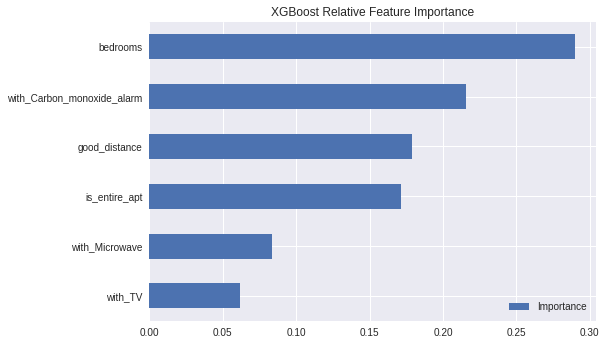

In [ ]:
# Plot feature importance
featureImport = pd.DataFrame(xgb_clf.feature_importances_, index=selected3)
featureImport.columns = ["Importance"]
featureImport.sort_values(["Importance"], ascending=True).plot(kind="barh")
plt.title("XGBoost Relative Feature Importance")
plt.show()

#Lasso

Creating table to be used

In [ ]:
data_subset = data.loc[:, selected + ['price']]
data_subset.dropna(inplace=True)
data_subset.head()

,host_is_superhost,good_distance,is_entire_apt,with_TV,with_Microwave,with_Carbon_monoxide_alarm,min_nights_greater_than_two,accommodates,instant_bookable,price
0,0,1,0,0,0,0,1,1,0,9.0
1,0,1,1,0,1,0,0,2,0,29.0
2,0,1,1,0,0,0,0,5,0,49.0
3,0,0,1,0,0,0,1,3,0,35.0
4,1,1,1,0,0,1,0,2,0,99.0


Further preparation of data - Standardization

In [ ]:
X = data_subset.loc[:,selected]
X = preprocessing.scale(X)
y = np.array(data_subset.price)

alphas_lasso, coefs_lasso, _ = lasso_path(X, y, eps = 5e-5)

(0.0006959022875469506,
 37.46979002031795,
 -3.731206585658369,
 22.85996884554736)

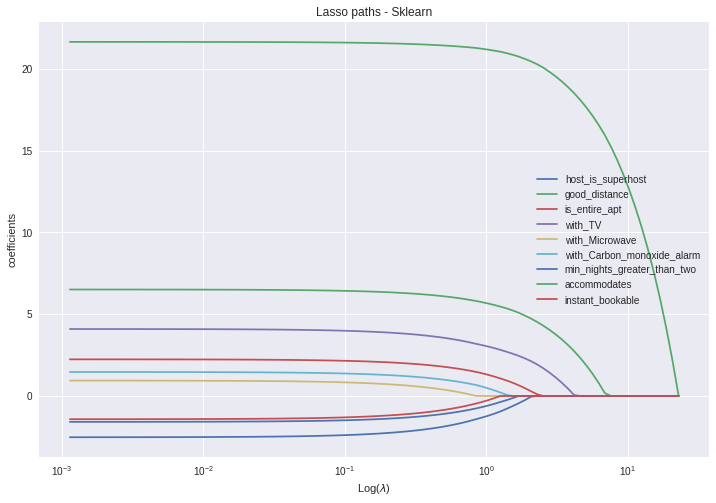

In [ ]:
# Display results
plt.figure(figsize = (12,8))

for i in range(X.shape[1]):
    plt.plot(alphas_lasso, coefs_lasso[i], label = selected[i])

plt.xscale('log')
plt.xlabel('Log($\\lambda$)')
plt.ylabel('coefficients')
plt.title('Lasso paths - Sklearn')
plt.legend()
plt.axis('tight')

<h1>Analysis prepared again with attributes used from Linear regrassion Model

In [ ]:
selected2 = ['good_distance', 'is_entire_apt', 'with_TV', 'bedrooms']

data_subset = data.loc[:, selected2 + ['price']]
data_subset.dropna(inplace=True)
data_subset.head()

,good_distance,is_entire_apt,with_TV,bedrooms,price
0,1,0,0,1.0,9.0
1,1,1,0,1.0,29.0
2,1,1,0,2.0,49.0
3,0,1,0,1.0,35.0
4,1,1,0,1.0,99.0


In [ ]:
X = data_subset.loc[:,selected2]
X = preprocessing.scale(X)
y = np.array(data_subset.price)

alphas_lasso, coefs_lasso, _ = lasso_path(X, y, eps = 5e-5)

(0.0003844465211898664,
 20.69993256352695,
 -0.6166021362457896,
 12.948644861161583)

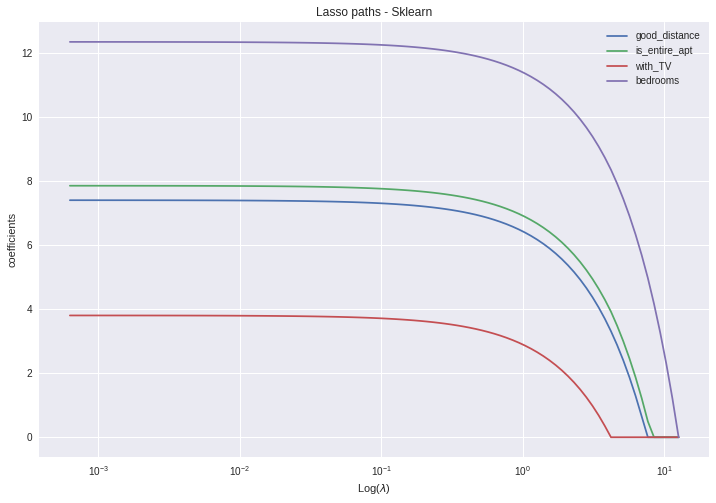

In [ ]:
# Display results
plt.figure(figsize = (12,8))

for i in range(X.shape[1]):
    plt.plot(alphas_lasso, coefs_lasso[i], label = selected2[i])

plt.xscale('log')
plt.xlabel('Log($\\lambda$)')
plt.ylabel('coefficients')
plt.title('Lasso paths - Sklearn')
plt.legend()
plt.axis('tight')

Last try - let's add some another attributes to those 

In [ ]:
selected3 = ['good_distance', 'is_entire_apt', 'with_TV', 'bedrooms', 'with_Carbon_monoxide_alarm', 'with_Microwave']

data_subset = data.loc[:, selected3 + ['price']]
data_subset.dropna(inplace=True)
data_subset.head()

,good_distance,is_entire_apt,with_TV,bedrooms,with_Carbon_monoxide_alarm,with_Microwave,price
0,1,0,0,1.0,0,0,9.0
1,1,1,0,1.0,0,1,29.0
2,1,1,0,2.0,0,0,49.0
3,0,1,0,1.0,0,0,35.0
4,1,1,0,1.0,1,0,99.0


In [ ]:
X = data_subset.loc[:,selected3]
X = preprocessing.scale(X)
y = np.array(data_subset.price)

alphas_lasso, coefs_lasso, _ = lasso_path(X, y, eps = 5e-5)

(0.0003844465211898664,
 20.69993256352695,
 -0.6163386623692024,
 12.943111909753249)

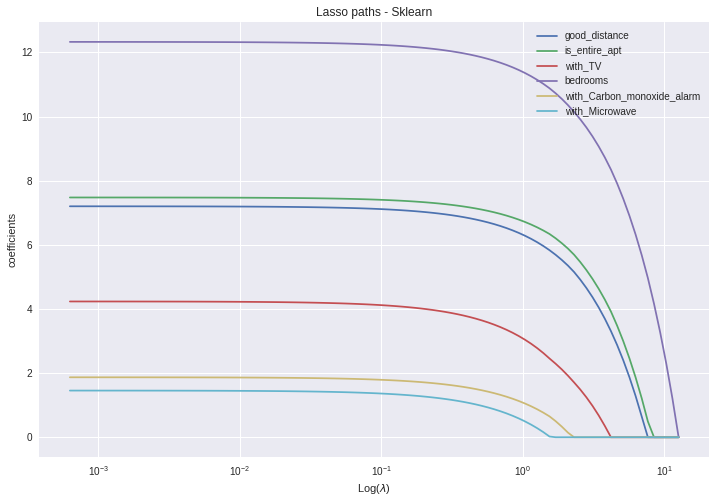

In [ ]:
# Display results
plt.figure(figsize = (12,8))

for i in range(X.shape[1]):
    plt.plot(alphas_lasso, coefs_lasso[i], label = selected3[i])

plt.xscale('log')
plt.xlabel('Log($\\lambda$)')
plt.ylabel('coefficients')
plt.title('Lasso paths - Sklearn')
plt.legend()
plt.axis('tight')

#XGBooost2

In [ ]:
data_subset = data.loc[:, selected + ['price']]
data_subset.dropna(inplace=True)
data_subset = data_subset.iloc[:1000,:]

#Selection of subsets 
X = data_subset.loc[:,selected]
#X = preprocessing.scale(X) #We don't have to scale it as trees don't care about distributions, means, and all that smart stuff
y = np.array(data_subset.price)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = xgboost.XGBRegressor(n_estimators=10, verbosity=1)
model.fit(X_train, y_train)

[21:23:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(n_estimators=10)

In [ ]:
predicted = model.predict(X_test)
print("mean squared error: ", mean_squared_error(y_test, predicted))
print("explained variance score: ", explained_variance_score(y_test, predicted))
print("max error: ", max_error(y_test, predicted))
print("mean_absolute_percentage_error: ", mean_absolute_percentage_error(y_test, predicted))
print("r2_score: ", r2_score(y_test, predicted))
print("mean poisson deviance: ", mean_poisson_deviance(y_test, predicted))

mean squared error:  2557.4123117676018
explained variance score:  0.14251188279444782
max error:  303.7727813720703
mean_absolute_percentage_error:  0.3831953552171757
r2_score:  -0.09284590710478535
mean poisson deviance:  33.643939261254644


In [ ]:
results_compared= {'Real values': y_test,
                   'Predicted_Values': predicted}
results_compared = pd.DataFrame(results_compared)

In [ ]:
results_compared.head(10)

,Real values,Predicted_Values
0,36.0,29.156345
1,9.0,60.122669
2,66.0,39.227219
3,29.0,39.227219
4,65.0,47.654343
5,44.0,27.742292
6,63.0,43.966507
7,38.0,40.831364
8,343.0,43.678062
9,129.0,64.571220


We can see, that results are not exactly the best right now - we could try djust selected attributes.

In [ ]:
data_subset = data.loc[:, selected2 + ['price']]
data_subset.dropna(inplace=True)
data_subset = data_subset.iloc[:1000,:]

#Selection of subsets 
X = data_subset.loc[:,selected2]
#X = preprocessing.scale(X) #We don't have to scale it as trees don't care about distributions, means, and all that smart stuff
y = np.array(data_subset.price)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = xgboost.XGBRegressor(n_estimators=10, verbosity=1)
model.fit(X_train, y_train)

[21:23:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(n_estimators=10)

In [ ]:
predicted = model.predict(X_test)
print("mean squared error: ", mean_squared_error(y_test, predicted))
print("explained variance score: ", explained_variance_score(y_test, predicted))
print("max error: ", max_error(y_test, predicted))
print("mean_absolute_percentage_error: ", mean_absolute_percentage_error(y_test, predicted))
print("r2_score: ", r2_score(y_test, predicted))
print("mean poisson deviance: ", mean_poisson_deviance(y_test, predicted))

mean squared error:  2087.642238540939
explained variance score:  0.23484907892636642
max error:  244.10211563110352
mean_absolute_percentage_error:  0.3794000258216115
r2_score:  0.008743702890118166
mean poisson deviance:  26.9008582730943


In [ ]:
results_compared= {'Real values': y_test,
                   'Predicted_Values': predicted}
results_compared = pd.DataFrame(results_compared)

In [ ]:
results_compared.head(10)

,Real values,Predicted_Values
0,59.0,38.427593
1,50.0,38.427593
2,80.0,38.427593
3,66.0,37.897884
4,28.0,27.815073
5,83.0,53.493549
6,23.0,27.504692
7,61.0,53.493549
8,113.0,86.043068
9,25.0,44.791607


Last try. if it won't work - maybe adjusting of hyperparameters will help

In [ ]:
data_subset = data.loc[:, selected3 + ['price']]
data_subset.dropna(inplace=True)
data_subset = data_subset.iloc[:1000,:]

#Selection of subsets 
X = data_subset.loc[:,selected3]
#X = preprocessing.scale(X) #We don't have to scale it as trees don't care about distributions, means, and all that smart stuff
y = np.array(data_subset.price)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = xgboost.XGBRegressor(n_estimators=10, verbosity=1)
model.fit(X_train, y_train)

[21:23:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(n_estimators=10)

In [ ]:
predicted = model.predict(X_test)
print("mean squared error: ", mean_squared_error(y_test, predicted))
print("explained variance score: ", explained_variance_score(y_test, predicted))
print("max error: ", max_error(y_test, predicted))
print("mean_absolute_percentage_error: ", mean_absolute_percentage_error(y_test, predicted))
print("r2_score: ", r2_score(y_test, predicted))
print("mean poisson deviance: ", mean_poisson_deviance(y_test, predicted))

mean squared error:  2062.4262868787746
explained variance score:  0.2464252120536342
max error:  246.1832046508789
mean_absolute_percentage_error:  0.3846333475597737
r2_score:  0.02071676532930722
mean poisson deviance:  26.703352077808795


In [ ]:
results_compared= {'Real values': y_test,
                   'Predicted_Values': predicted}
results_compared = pd.DataFrame(results_compared)

In [ ]:
results_compared.head(10)

,Real values,Predicted_Values
0,59.0,39.634083
1,50.0,39.634083
2,80.0,37.838276
3,66.0,38.048798
4,28.0,29.127722
5,83.0,53.699093
6,23.0,29.125612
7,61.0,54.680023
8,113.0,77.534515
9,25.0,45.915993


In [ ]:
results_compared= {'Real values': y_test_XGB_1,
                   'Predicted_Values': predicted_XGB_1}
results_compared = pd.DataFrame(results_compared)

In [ ]:
results_compared.head(10)

,Real values,Predicted_Values
762,28.0,36.258762
1656,20.0,52.178730
265,22.0,44.767395
577,90.0,63.869312
592,50.0,66.918930
1688,48.0,41.353745
135,66.0,73.751350
1744,100.0,76.462875
1798,39.0,51.501076
1979,70.0,43.127762


In [ ]:
results_compared= {'Real values': y_test_XGB_2,
                   'Predicted_Values': predicted_XGB_2}
results_compared = pd.DataFrame(results_compared)

In [ ]:
results_compared.head(10)

,Real values,Predicted_Values
762,28.0,27.341074
1656,20.0,43.625351
265,22.0,38.373043
577,90.0,61.457142
592,50.0,60.794827
1688,48.0,64.330246
135,66.0,71.408768
1744,100.0,49.868053
1798,39.0,64.330246
1979,70.0,58.369171


<h1> Conclusions
<h1> So far, the best result given by XGBoost is first example from first approach to XGB

<h1> So for now those set of parameters shall be used, to build final Linear Regression model

# Ceteris paribus

Lets calculate number of bedrooms

In [ ]:
['bathrooms', 'bedrooms', 'beds', 'guests_included', 'minimum_nights', 'number_of_reviews', 'review_scores_rating']
data_temp = pd.DataFrame({"bedrooms" : [x for x in range(30)]})
data_temp['bathrooms'] = 1
data_temp['beds'] = 5 
data_temp['guests_included'] = 1
data_temp['minimum_nights'] = 1
data_temp['number_of_reviews'] = 100
data_temp['review_scores_rating'] = 4.8
data_temp

data_temp.head()

,bedrooms,bathrooms,beds,guests_included,minimum_nights,number_of_reviews,review_scores_rating
0,0,1,5,1,1,100,4.8
1,1,1,5,1,1,100,4.8
2,2,1,5,1,1,100,4.8
3,3,1,5,1,1,100,4.8
4,4,1,5,1,1,100,4.8


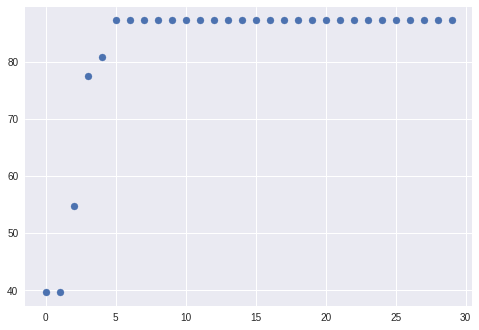

In [ ]:
data_temp = data_temp.reindex(columns=data_subset.columns)
data_temp.drop('price', axis=1, inplace=True)

#Predict - taken from calculated value wfrom first XGB
predictions_temp = model.predict(data_temp)

#Plot
plt.scatter(x=data_temp.bedrooms, y=predictions_temp)
plt.show()

From this plot, we can see, that significantly highest price may be gathered from 3 bedrooms.

Lets try different approach - The same, as with bedrooms, but in first XGB - so the one with selected3 attributes  

In [ ]:
# Checking the best room number for well located whole apartments with TV, alarm and microwave
['bedrooms', 'good_distance', 'is_entire_apt', 'with_TV', 'with_Carbon_monoxide_alarm', 'with_Microwave'] # This is the firs selected, but in place of acomodities, there are bedrooms
data_temp = pd.DataFrame({"bedrooms" : [x for x in range(10)]})
data_temp['good_distance'] = 1
data_temp['is_entire_apt'] = 1
data_temp['with_TV'] = 1
data_temp['with_Carbon_monoxide_alarm'] = 1
data_temp['with_Microwave'] = 1
data_temp

data_temp.head()

,bedrooms,good_distance,is_entire_apt,with_TV,with_Carbon_monoxide_alarm,with_Microwave
0,0,1,1,1,1,1
1,1,1,1,1,1,1
2,2,1,1,1,1,1
3,3,1,1,1,1,1
4,4,1,1,1,1,1


In [ ]:
# Code needed, to turn attribute names back anfter XGB modification
xgb_clf.get_booster().feature_names = ['bedrooms', 'good_distance', 'is_entire_apt', 'with_TV', 'with_Carbon_monoxide_alarm', 'with_Microwave']
xgb_clf.get_booster().feature_names

['bedrooms',
 'good_distance',
 'is_entire_apt',
 'with_TV',
 'with_Carbon_monoxide_alarm',
 'with_Microwave']

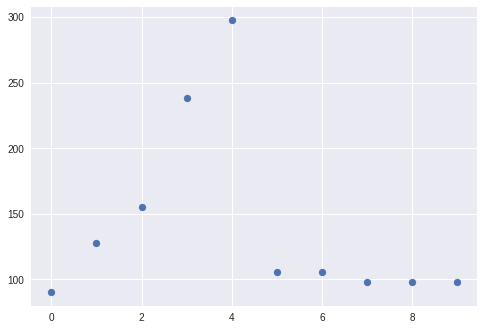

In [ ]:
data_subset = data.loc[:, selected3 + ['price']]
data_subset.dropna(inplace=True)
data_subset = data_subset.iloc[:1000,:]
data_temp = data_temp.reindex(columns=data_subset.columns)
data_temp.drop('price', axis=1, inplace=True)

#Predict
predictions_temp = xgb_clf.predict(data_temp)

#Plot
plt.scatter(x=data_temp.bedrooms, y=predictions_temp)
plt.show()

Here we can see, that the biggest jumps were at 3 bedrooms - so we are looking for such a location. But of course 2 also seems to be nice

# Shapley

In [ ]:
explainer = shap.TreeExplainer(xgb_clf)
X = data[selected3]
shap_values = explainer.shap_values(X)

In [ ]:
X.iloc[0,:]

bedrooms                      1.0
good_distance                 1.0
is_entire_apt                 0.0
with_TV                       0.0
with_Carbon_monoxide_alarm    0.0
with_Microwave                0.0
Name: 0, dtype: float64

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

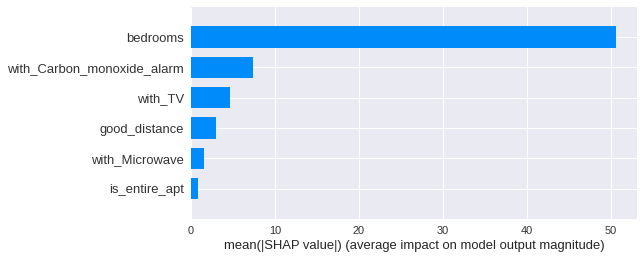

In [ ]:
shap.summary_plot(shap_values, X, plot_type="bar")

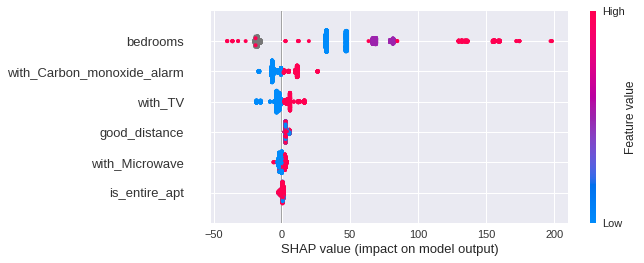

In [ ]:
shap.summary_plot(shap_values, features=X, feature_names=X.columns)